**Instituto Tecnológico de Aeronáutica – ITA**

**Visão Computacional - CM-203**

**Professores:** 

Marcos Ricardo Omena de Albuquerque Maximo

Gabriel Adriano de Melo


**Orientações padrão:**

Antes de você entregar o Lab, tenha certeza de que tudo está rodando corretamente (sequencialmente): Primeiro, **reinicie o kernel** (`Runtime->Restart Runtime` no Colab ou `Kernel->Restart` no Jupyter), depois rode todas as células (`Runtime->Run All` no Colab ou `Cell->Run All` no Jupyter) e verifique que as células rodem sem erros, principalmente as de correção automática que apresentem os `assert`s.

É muito importante que vocês não apaguem as células de resposta para preenchimento, isto é, as que contenham o `ESCREVA SEU CÓDIGO AQUI` ou o "ESCREVA SUA RESPOSTA AQUI", além das células dos `assert`, pois elas contém metadados com o id da célula para os sistemas de correção automatizada e manual. O sistema de correção automatizada executa todo o código do notebook, adicionando testes extras nas células de teste. Não tem problema vocês criarem mais células, mas não apaguem as células de correção. Mantenham a solução dentro do espaço determinado, por organização. Se por acidente acontecer de apagarem alguma célula que deveria ter a resposta, recomendo iniciar de outro notebook (ou dar um `Undo` se possível), pois não adianta recriar a célula porque perdeu o ID. Ou então você baixa e abre o notebook como texto (é um JSON) e readiciona o campo de ID. Neste ano nós também colocamos um comentário nessas células que é igual ao ID delas, para ser um failsafe em caso de sumirem com o ID das células, então NÃO apaguem esse comentário com ID.

Os notebooks vocês podem alterar à vontade, podem criar novas células, modificar as existentes, apagar (a menos das células de correção). O corretor automático executará todas as células e verificará a presença de erro nos `asserts`, depois haverá a correção manual das questões com apreciação da resposta e comentários gerados em HTML. Se ele não achar a célula com os asserts, fica sem a nota da questão, se ele não achar a célular com a questão, fica sem os comentários. Mas vocês podem escreve sim código fora dos espaço delemitado pelo `ESCREVA SEU CÓDIGO AQUI` sem problemas, só não altera a assinatura da função. Esse espaço foi pensado para facilitar a sua implementação.

Os Notebooks foram programados para serem compatíveis com o Google Colab, instalando as dependências necessárias automaticamente a baixando os datasets necessários a cada Lab. Os comandos que se inicial por ! (ponto de exclamação) são de bash e também podem ser executados no terminal linux, que justamente instalam as dependências.

---

# Laboratório 1: Introdução e Classificação Simples

Neste laboratório você irá realizar algumas operações básicas com imagens (leitura e manipulações); você programará um classificador entre cães e gatos manualmente; e, você também usará o framework do FastAI para treinar uma rede neural profunda nesse mesmo problema.

Além das questões avaliadas, acrescentamos também um problema que nos deparamos a fazer a aula e que não tivemos tempo de resolver: o problema do blend dos canais de cores das 3 imagens da capivara no Google Slides.

In [1]:
# from pathlib import Path             # Já importado pelo fastai
# from typing import Callable          # Já importado pelo fastai
# import numpy as np                   # Já importado pelo fastai
# import pandas as pd                  # Já importado pelo fastai
# from PIL import Image                # Já importado pelo fastai
# from matplotlib import pyplot as plt # Já importado pelo fastai
from fastai.vision.all import *        # fastai==2.7.12
import cv2                             # opencv-contrib-python-headless==4.8.0.74



# Caso esteja executando o notebook localmente, reimplementa o cv2_imshow
from IPython.utils import io
from IPython.display import display
import warnings
try:
    from google.colab.patches import cv2_imshow
except:
    def cv2_imshow(img):
        display(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

# Faz o numpy imprimir mais números por linha
np.set_printoptions(edgeitems=40, linewidth=130)

In [2]:
# Verifica se já foram baixadas as imagens do drive, baixando-as e descompactando se necessário
! [ ! -d "/content/cats_vs_dogs" ] && gdown -O /content/cats_vs_dogs.zip "1QpBJS43Y-yKykEllxmLGW8VXsVLO82Po" &&  unzip -q /content/cats_vs_dogs.zip -d /content && rm /content/cats_vs_dogs.zip
! [ ! -d "/content/cats_vs_dogs" ] && wget -P /content/ "http://ia.gam.dev/cm203/23/lab1/cats_vs_dogs.zip" &&  unzip -q /content/cats_vs_dogs.zip -d /content  && rm /content/cats_vs_dogs.zip
base_path = Path("/content/cats_vs_dogs")
%cd /content

/content


## Operações Básicas (4 pontos)

### Leitura e Visualização de uma imagem (apenas ilustrativo)

Vamos carregar algumas imagens aqui, fique livre para escolher qualquer imagem:

(escolhemos filhotes por serem mais ditáticos ...)

In [3]:
caminho_imagem_cat = str(base_path/'train'/'cat'/'00125.jpg')
caminho_imagem_dog = str(base_path/'train'/'dog'/'00042.jpg')
caminho_imagem_cat, caminho_imagem_dog

('/content/cats_vs_dogs/train/cat/00125.jpg',
 '/content/cats_vs_dogs/train/dog/00042.jpg')

Vamos carregar uma imagem usando o Pillow, por meio da função `Image.open`:

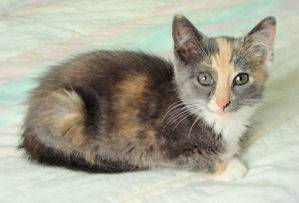

In [4]:
img_pillow = Image.open(caminho_imagem_cat)
img_pillow

A imagem Pillow é um objeto próprio dela, mas pode ser convertido para uma matriz numpy por meio do casting `np.array(img_pillow)`

In [ ]:
type(img_pillow)

Vamos carregar uma imagem usando o OpenCV, para isso usamos a função `cv2.imread`. Já para exibi-la, no Colab usamos o cv2_imshow (mas no notebook local acaba sendo o próprio PIL):

Perceba também que o tipo da imagem que o OpenCV retorna já é uma matriz numpy (`numpy.ndarray`)

In [ ]:
img_opencv = cv2.imread(caminho_imagem_dog)
cv2_imshow(img_opencv)
type(img_opencv)

Vamos observar os pixels da Imagem no formato de tabela (planilha), vamos carregar uma imagem de um gato menor (subamostrada e só com um canal).

Perceba que a subamostragem foi realizado da forma mais rápida (bronca) possível: usando stepping `::2`. Em vez de calcular a média do 2x2 pixels, nós só pegamos o valor de 1 que está no topo esquerdo desse 2x2, isso é, começando do índice zero e pegando o próximo a 2 (índices pares).

Vamos usar a biblioteca Pandas, para fazer uma exibição tipo planilha.

In [ ]:
pequeno_gato = cv2.imread(str(base_path/'train'/'cat'/'00216.jpg'))[::2, ::2, 1]
cv2_imshow(pequeno_gato)
df = pd.DataFrame(pequeno_gato)
df.style.set_properties(**{'font-size':'7pt'}).background_gradient('gray', axis=None, vmin=0, vmax=255)

Veja também os números em si como uma matriz numpy (apenas os 30 primeiros em cada eixo):

In [ ]:
pequeno_gato[:20, :20]

Vamos ver a imagem no formato de 'função' matemática, nesse plot de grids acaba sendo uma simples função que interpola linearmente os pontos:

In [ ]:
image_array = pequeno_gato.astype('float64')

x = np.arange(image_array.shape[1])
y = np.arange(image_array.shape[0])
x, y = np.meshgrid(x, y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(y, x, image_array, cmap='gray', rcount=image_array.shape[0], ccount=image_array.shape[1])
ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.set_zlabel('Valor')
ax.set_zlim(0, 800) # MUDE ISSO PARA VER A ESCALA

# MUDE ISSO PARA VER DE OUTRO ANGULO
ax.view_init(50, 10)

plt.show() # Exibe o plot

Olha o que acontece quando trocamos o formato do OpenCV (BGR) pelo o do Pillow (RGB):

In [ ]:
cv2_imshow(np.array(img_pillow))

O Matplotlib também tem a mesma convenção do RGB que o Pillow, e usa a função `imshow`:

In [ ]:
plt.figure()
plt.imshow(img_opencv)

Enquanto o Pillow, dentro do Jupyter notebook, mostra a imagem na sua resolução original (e em um formato PNG), o Matplotlib altera a resolução da imagem de acordo com a resolução (DPI) do plot, realizando um redimensionamento contínuo da imagem.

Veja inclusive que ele coloca uma escala de `x` e `y` em pixels, e trata a imagem como se fosse uma função.

### Converter entre BGR e RGB (0,5 pontos)

**Explicação sobre o assunto**

Então você deve ter percebido que trocar o canal vermelho pelo azul, deixa a imagem com uma percepção de cor completamente diferente. A cor da pele das pessoas tende a ficar azul, mas em certas imagens também pode ser pouco perceptível que as cores estão trocadas, então tem que ficar atento no próprio código!

**Enunciado da Questão**

Impletemente uma função que converte uma imagem do formato BGR para o RGB ou vice-versa. Neste exemplo, use apenas operações de indexação da matriz em numpy, é para exercitar a sua prática com índices. Nesta questão **NÃO** use `np.transpose` nem `cv2.cvtColor`. **NÃO** use LLMs.  **NÃO** pesquise a resposta na internet.

<details><summary><b>Dica para a resposta</b></summary>
<p>
Veja os slides da aula sobre indexação. P.S.: Primeiro tente resolver as questões e só depois abra as dicas!
Essa questão dá para resolver com uma linha, com uma operação de indexação (vetorizada). Ou também você poderia fazer com um for-loop (bronco).
</p>
</details>

In [ ]:
# questao_bgr_rgb

def converte_BGR_RGB(imagem: np.ndarray):
    """ Recebe uma imagem no formato BGR ou RGB e converte para o outro formato.
    :param imagem: imagem com shape (H, W, 3) d
    Retorna uma nova imagem convertida (não é para modificar a imagem original).
    """
    imagem_convertida = np.zeros_like(imagem) # Nem precisa usar essa inicialização
    # ESCREVA SEU CÓDIGO AQUI (pode apagar este comentário, mas não apague esta célula para não perder o ID)
    raise NotImplementedError()
    return imagem_convertida

In [ ]:
# testa_bgr_rgb

pix = np.array([[[1, 2, 3], [22, 11, 44]]])
inv_pix = np.array([[[3, 2, 1], [44, 11, 22]]])
assert np.all(converte_BGR_RGB(pix) == inv_pix)

Veja, agora a cor deve ficar correta:

In [ ]:
plt.imshow(converte_BGR_RGB(img_opencv))

### Converter de RGB para *grayscale* (0,5 pontos)

**Explicação sobre o assunto**

Para cada pixel da imagem $I(y, x)$ formada pelos canais azul $B(y, x)$, verde $G(y, x)$ e vermelho $R(y, x)$, na convenção do OpenCV $I(y, x) = \left(B(y, x), G(y, x), R(y, x)\right)$ aplicamos uma transformação linear a cada um desses canais para obter um novo canal de cinza $C(y, x)$. Essa transformação é aplicada a cada pixel $(y, x)$ da imagem:

$C(y, x) = 0.114 B(y, x) + 0.587G(y, x) + 0.299R(y, x)$.

Esses coeficientes dependem da sensibilidade do sensor e do meio de exibição (tela) de acordo com a percepção humana. Os coeficientes acimas são para imagens digitais de acordo com a especificação ITU BT.601.

Nota: essa transformação só vale para espaços lineares, quando os valores de cada pixel da imagem não está representada como um resultado de uma exponenciação pelo coeficiente gama $\gamma$: $I_\text{não linear}(y, x) = I(y, x)^\gamma$. Caso a imagem não esteja representada linearmente, é necessário fazer a tranformação inversa dessa exponenciação por gama.

Nos labs vamos sempre assumir que já está no espaço linear (apesar de provavelmente isso não ser verdade, pelo fato de serem imagens de câmeras).

**Enunciado da Questão**

Implemente a sua própria função abaixo que realiza a conversão para escala de cinza $C(y, x) = 0.114 B(y, x) + 0.587G(y, x) + 0.299R(y, x)$, de uma imagem BGR. **NÃO** use a função do `cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)`, implemente a sua própria a partir de operações de matrizes com o numpy. **NÃO** use LLMs.  **NÃO** pesquise a resposta na internet.

<details><summary><b>Dica</b></summary>
<p>
Use `matriz.astype(np.float64)` ou  `matriz.astype(np.uint8)` para converter uma matriz numpy para float64 ou uint8 . O numpy aceita operações com matrizes (caso você não queira somar pixel a pixel dentro de um loop), basta você indexar cada canal, por exemplo matrix[:, :, 0].

Essa questão dá para resolver com uma linha, com uma operação de indexação (vetorizada), escrevendo a fórmula da transformação linear.
</p>
</details>

In [ ]:
# questao_grayscale

def converte_BGR_para_cinza(imagem_BGR: np.ndarray):
    """
    Implemente a sua própria função que converte uma imagem colorida de três canais BGR (blue, green, red) para
    escala de Cinza C conforme a equação C(y, x) = 0.114 B(y, x) + 0.587G(y, x) + 0.299R(y, x) aplicada em cada
    pixel (y, x).
    :param imagem_BGR: Matriz (H, W, 3) que representa a imagem de altura H, largura W e 3 canais de cores BGR
    Retorna uma nova imagem resultante (H, W) em escala de cinza no formato de 8-bits positivos.
    Utilize truncamento para aproximar o resultado intermediário que seria em ponto flutuante (para correção)
    """
    imagem_cinza = np.zeros(imagem_BGR.shape[:-1], dtype=np.uint8) # Nem precisa usar essa inicialização
    # ESCREVA SEU CÓDIGO AQUI (pode apagar este comentário, mas não apague esta célula para não perder o ID)
    raise NotImplementedError()
    return imagem_cinza

In [ ]:
# testa_grayscale

img = np.arange(180, dtype=np.uint8).reshape(6, 10, 3)
assert converte_BGR_para_cinza(img).dtype == np.uint8
assert np.all(converte_BGR_para_cinza(img) == np.array(
      [[  1,   4,   7,  10,  13,  16,  19,  22,  25,  28],
       [ 31,  34,  37,  40,  43,  46,  49,  52,  55,  58],
       [ 61,  64,  67,  70,  73,  76,  79,  82,  85,  88],
       [ 91,  94,  97, 100, 103, 106, 109, 112, 115, 118],
       [121, 124, 127, 130, 133, 136, 139, 142, 145, 148],
       [151, 154, 157, 160, 163, 166, 169, 172, 175, 178]], dtype=np.uint8))
assert converte_BGR_para_cinza(np.array([100, 0, 0], dtype=np.uint8).reshape(1, 1, 3))[0, 0] == 11

Vejamos o resultado em uma imagem:

In [ ]:
plt.imshow(converte_BGR_para_cinza(img_opencv), cmap='gray', vmin=0, vmax=255)

Agora você poderia fazer um plot com o matplotlib, sem passar o argumento do `cmap` e achar que a imagem ainda está colorida. Mas não é isso que está acontecendo. Lembra que o matplotlib interpreta a imagem como se fosse uma função matemática? Ele utiliza uma escala de cor (colormap, que lembra um mapa de calor) e associa o valor da função em um ponto a uma cor.

O padrão dele (`None`) é o `viridis` que vai do azul escuro ao amarelo claro, na figura anterior usamos o `gray` que vai do preto para o branco, tem também o `Greys` que vai do branco para o pretor e muitas outras escalas de cor, `plasma`, `inferno`, `rainbow` e [muito mais](https://matplotlib.org/stable/tutorials/colors/colormaps.html):

In [ ]:
plt.imshow(converte_BGR_para_cinza(img_opencv)) # cmap='inferno' # veja outros mapas de cor
plt.colorbar()

### Ganho aditivo (deslocamento) e multiplicativo (0,5 ponto)

**Explicação sobre o assunto**

Ainda com manipulação de cores, que são operações que se realizam para todos os pixels de uma mesma imagem, podemos fazer um "ganho aditivo" e um "ganho multiplicativo".

O aditivo tem o efeito de "deslocar" todos os valores de cor, alterando o valor de cada pixel para cima (mais claro) ou para baixo (mais escuro). No entanto, esta operação não distingue entre diferentes níveis de cor: todos os pixels são aumentados ou diminuídos igualmente.

O multiplicativo "escala" todos os valores de cor, afetando pixels de diferentes níveis de cor de forma diferente (pixels mais claros são tornados mais claros que os escuros). Um exemplo disso é o ajuste do contraste de uma imagem. Ao contrário do ganho aditivo, o ganho multiplicativo.

Quando se trata de manipulação de cores, o ganho aditivo e multiplicativo pode ser aplicado a cada um dos canais de cor (vermelho, verde, azul) separadamente. Isso permite que você ajuste não apenas a luminosidade e o contraste da imagem, mas também seu equilíbrio de cores. Por exemplo, adicionando um ganho aditivo ao canal vermelho, você pode fazer a imagem parecer mais "quente", enquanto adicionar um ganho aditivo ao canal azul pode fazer a imagem parecer mais "fria".

Para cada pixel $(y, x)$ na imagem de $I$, aplica-se um ganho multiplicativo $\alpha$ e um ganho aditivo $\beta$ (um deslocamento). Assim, a imagem resultante $I_{r}$ é calculada por $I_{r}(y, x) = \alpha \cdot I(y, x) + \beta$

**Enunciado da Questão**

A função `cv2.convertScaleAbs(image, alpha, beta)` realiza exatamente esse procedimento.

Agora é a sua vez de implementar essa função. Ela obedece a equação $I_{r}(y, x) = \alpha \cdot I(y, x) + \beta$. Assuma que as cores e intensidades estão todas em escala linear. **NÃO** use LLMs.  **NÃO** pesquise a resposta na internet.

<details><summary><b>Dica</b></summary>
<p>
Use `matriz.astype(np.float64)` / `np.uint8` para converter uma matriz numpy para float64/uint8 . Use também `np.clip` para limitar o valor mínimo e máximo.
</p>
</details>

In [ ]:
# questao_ganho

def ganho(imagem: np.ndarray, multiplicativo: float, aditivo: float):
    """
    Implemente a sua própria função de ganho aditivo e multiplicativo (sem usar o cv2.convertScaleAbs), apenas numpy
    Atente para não ocorrer overflow durante as suas operações matemáticas, e que o tipo das imagens é uint8.
    :param imagem: Matriz (H, W) ou (H, W, C) que representa a imagem de altura H, largura W e C canais de cores
    :param multiplicativo: Ganho que deve multiplicar cada pixel da imagem, pode ser um número float.
    :param aditivo: Ganho aditivo que deve ser somado a cada pixel da imagem, pode ser um número float.
    Retorna uma nova imagem resultante da aplicação de um ganho aditivo e multiplicativo, o resultado deve ser
    expresso no formato de imagem 8-bits positivos, dentro dos seus limites de representação (entre 0 e 255).
    Isto é, se o resultado matemático for negativo, deve ser representado como zero, e se maior que 255, 255.
    """
    imagem_com_ganho = np.zeros_like(imagem) # Nem precisa usar essa inicialização
    # ESCREVA SEU CÓDIGO AQUI (pode apagar este comentário, mas não apague esta célula para não perder o ID)
    raise NotImplementedError()
    return imagem_com_ganho

In [ ]:
# testa_ganho

assert np.all(ganho(np.ones((9, 9), dtype=np.uint8), 30, 50) == 80)
assert ganho(np.ones((9, 9), dtype=np.uint8), 180, 160).dtype == np.uint8
assert np.all(ganho(np.ones((9, 9), dtype=np.uint8), 30, -100) == 0)

Veja o que acontece com um ganho maior que 1 (multiplicativo) e positivo (aditivo).

Observe que já regiões da imagem que ficaram saturadas (tudo branco):

(isso se você tiver implementado corretamente, se não vai ficar uma cor esquisita do overflow, ou melhor, tenta implementar com overflow e vem o bug que acontece)

In [ ]:
cv2_imshow(ganho(img_opencv, 1.3, 50))

### Luminosidade Média da imagem (0,5 pontos)

**Explicação sobre o assunto**

Uma das features mais simples de se obter de uma imagem é justamente com relação à sua cor, isto é, a cor média de uma imagem inteira, seja sobre em seus canais R, G ou B ou ainda de sua luminosidade Y.

Uma intuição sobre isso seria: caso a imagem fosse reduzida a apenas um pixel (você estivesse olhando de muito longe) qual a cor / luminosidade que você enxergaria?

**Enunciado da Questão**

Implemente agora uma função que calcula a luminosidade média de uma imagem. Se ela for colorida, converta para a grayscale usando a função acima (assumindo escala linear e BGR). Se ela tiver apenas um canal, assuma que já é de luminosidade e calcule a sua média. Use apenas operações básicas do Numpy. **NÃO** use LLMs.  **NÃO** pesquise a resposta na internet.

<details><summary><b>Dica</b></summary>
<p>
Use `np.sum` ou  `np.mean`.
</p>
</details>

In [ ]:
# questao_luminosidade

def luminosidade_media(imagem: np.ndarray):
    """
    :param imagem: Matriz numpy (H, W) ou (H, W, 3) BGR que representa uma imagem
    Retorna uma nova imagem convertida (não é para modificar a imagem original).
    """
    luminosidade_media = 0.0  # Nem precisa usar essa inicialização
    # ESCREVA SEU CÓDIGO AQUI (pode apagar este comentário, mas não apague esta célula para não perder o ID)
    raise NotImplementedError()
    return luminosidade_media

In [ ]:
# testa_luminosidade

assert abs(luminosidade_media(np.array([[[100, 100, 100]]])) - 100) < 1e-2
assert abs(luminosidade_media(np.array(
      [[142, 147, 159, 159, 114, 120, 117, 152],
       [142, 148, 159, 163, 121, 111, 116, 154],
       [138, 148, 154, 167, 133, 102, 119, 152],
       [134, 145, 149, 166, 142,  97, 124, 145],
       [140, 154, 148, 153, 149, 101, 118, 137],
       [140, 150, 154, 154, 155,  97, 116, 132]])) - 138.27) < 1e-2

Vejamos a luminosidade média de algumas imagens:

In [ ]:
luminosidade_media(img_opencv), luminosidade_media(np.array(img_pillow))

### Calcular Histograma (0,5 pontos)

**Explicação sobre o assunto**

Uma forma interessante de analisar a iluminação é verificar a distribuição dos valores de cada pixel na imagem, isto é, construir um histograma. Geralmente ele é aplicado em cada canal de cores separadamente, ou ainda na imagem em escala de cinza.

Isso já é um 'avanço' sobre a cor média de uma imagem, pois no lugar de gerar apenas uma feature (média), geramos uma distribuição de features (256).

Assim para construir um histograma, basta contar quantos pixels tem um determinado valor, que no caso das imagens de 8 bits, são valores que estão entre 0 e 255 (inclusive).

**Enunciado da Questão**

Implemente a função abaixo que retorna a contagem dos valores de cada pixel em uma imagem apenas com um canal de cor. Não use a função `plt.hist` nem `np.histogram`, é para você implementar a sua própria a partir de operações básicas do Numpy.  **NÃO** use LLMs. **NÃO** pesquise a resposta na internet.

<details><summary><b>Dica</b></summary>
<p>
Percorra cada pixel da imagem, contando o seu valor. Outra possibilidade é percorrer cada valor possível e comparar o valor de todos os pixels da imagem com esse valor (parelelamente) usando o `np.sum` para ver quantos resultados retornaram True.

Essa questão não conseguimos implementar sem for-loop, apesar de termos um loop só com 256 iterações e o resto é vetorizado. Se alguém conseguir melhor ficaremos felizes (mas é claro, sem usar a função `np.histogram`).
</p>
</details>

In [ ]:
# questao_histograma

def distribuicao(imagem_mono: np.ndarray):
    """
    Implemente a sua própria função que realiza a contagem do valor de cada pixel.
    :param imagem_mono: Matriz (H, W) imagem de altura H, largura W
    Retorna um vetor (v) com a contagem (q) dos valores de intensidade luminosa (i) da imagem v[i] = q.
    """
    contagem = np.zeros(256, dtype=np.uint64)
    # ESCREVA SEU CÓDIGO AQUI (pode apagar este comentário, mas não apague esta célula para não perder o ID)
    raise NotImplementedError()
    return contagem

In [ ]:
# testa_histograma

img = np.arange(14*14, dtype=np.uint8).reshape(14, 14) + np.eye(14) + 30
contagem_histograma = distribuicao(img)
assert np.all(contagem_histograma == np.array(
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2,
   1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1,
   1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1,
   1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1,
   1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=np.uint64))

Visualizando essa contagem em um gráfico de barras:

In [ ]:
canal_verde = img_opencv[:, :, 1]
plt.bar(np.arange(256), distribuicao(canal_verde), width=1)

O matplotlib também já tem uma função `plt.hist` que já realiza automaticamente o cálculo desse histograma (de um vetor unidirecional). Para isso temos que transformar uma matriz em um vetor que é a concatenação das linhas, como se desenrolássemos a sequência de pixels da matrix `matrix.ravel()` ou `.flatten()`. Só atente para colocar a quantidade de bins entre 0 e 255:

In [ ]:
n, bins, patches = plt.hist(canal_verde.ravel(), bins=np.arange(256))
n[:40] # Olhando o valor dos 40 primeiros elementos que ele conta

Normalmente, os histogramas podem ser normalizados, de forma que o somatório dos valores dos bins seja igual a 1. Dessa forma teríamos uma densidade de probabilidade (no caso discreto é a própria probabilidade de amostrar o valor daquele bin).

Histogramas são bons não apenas para visualizar a distribuição da 'cor' dos pixels em uma imagem, mas também podem ser utilizado para visualizar as 'features' de um dataset.

### Espelhar horizontalmente e/ou verticalmente (0,5 ponto)

**Explicação sobre o assunto**

Agora vamos realizar algumas operações discretas sobre a própria imagem. Com essas operações você pode continuar pensando que a imagem é uma matriz, e que iremos apenas reposicionar os elementos dessa matriz. É mais uma prática de indexação e pensamento no paradigma vetorizado.

Uma forma simples de reposicionar esses elementos da matriz é simplesmente espelhá-los sobre o eixo X ou sobre o eixo Y. Inclusive essa operação de espelhamento é muito utilizada quando se quer aumentar o conjunto de imagens disponíveis no dataset (o chamado data augmentation).

A imagem espelhada no eixo X `imgX` tem a seguinte propriedade: `img[y, x] == imgX[y, W-1-x]`. Analogamente ao eixo Y: `img[y, x] == imgY[H-1-y, x]`. Onde `W` é a largura, `H` é a altura da imagem original `img`.

**Enunciado da Questão**

Implemente uma função que espelha a imagem em cada eixo (X e/ou Y), pode ser as 4 combinações (não espelha, espelha apenas X, espelha apenas Y, espelha ambos).  **NÃO** use LLMs.  **NÃO** pesquise a resposta na internet.
 
<details><summary><b>Dica</b></summary>
<p>
Lembre-se da indexação, dá para resolver com 2 ifs de 1 linha cada.
</p>
</details>

In [ ]:
# questao_espelha

def espelhar_imagem(imagem: np.ndarray, espelha_x: bool, espelha_y: bool):
    """ Espelha a imagem em cada eixo (X e/ou Y)
    :param imagem: Matrix numpy (H, W) ou (H, W, 3) que representa a imagem
    :param espelha_x: Valor boleano que indica se a imagem está espelhada no eixo X
    :param espelha_y: Valor boleano que indica se a imagem está espelhada no eixo Y
    
    Retorna uma nova imagem espelhada de acordo com os argumentos. Não é para alterar
    a matriz do argumento.
    """
    imagem_espelhada = np.copy(imagem)
    # ESCREVA SEU CÓDIGO AQUI (pode apagar este comentário, mas não apague esta célula para não perder o ID)
    raise NotImplementedError()
    return imagem_espelhada

In [ ]:
# testa_espelha

img = np.arange(7*4, dtype=np.uint8).reshape(4, 7)
assert np.all(espelhar_imagem(img, False, False) == np.array(
  [[ 0,  1,  2,  3,  4,  5,  6],
   [ 7,  8,  9, 10, 11, 12, 13],
   [14, 15, 16, 17, 18, 19, 20],
   [21, 22, 23, 24, 25, 26, 27]], dtype=np.uint8))
assert np.all(espelhar_imagem(img, True, False) == np.array(
  [[ 6,  5,  4,  3,  2,  1,  0],
   [13, 12, 11, 10,  9,  8,  7],
   [20, 19, 18, 17, 16, 15, 14],
   [27, 26, 25, 24, 23, 22, 21]], dtype=np.uint8))

Observe o seu efeito nas imagens, tente com `True, True` também (já é spoiler da próxima questão):

In [ ]:
cv2_imshow(espelhar_imagem(img_opencv, False, True))

### Rotação de imagem de 90 graus (1 ponto)

**Explicação sobre o assunto**

Agora também temos mais outra prática com operações discretas. Outra dessas operações simples é a rotação de uma imagem de 90 graus, que nessa questão será a direita (dedão aponta para dentro da tela pela regra da mão direita).

A imagem rotacionada a direita `imgR` satisfaz a propriedade: `img[y, x] == imgR[x, H-1-y]`, onde `W` é a largura e `H` é a altura da imagem original `img`.

Na aula de processamento de imagens (aula 4) vocês verão também como é possível rotacionar uma . Nessa aula a ideia principal será em pensar na imagem como uma função contínua.

(O Gabriel até iria colocar essa questão aqui depois dessa, mas iria ultrapassar o tempo esperado de 80% da turma finalizar em bem menos de 3 horas, não esqueçam do feedback no final do lab, é importante para a calibração)

**Enunciado da Questão**

Use apenas operações básicas do Numpy para retornar uma nova imagem rotacionada a direita. **NÃO** use LLMs. **NÃO** pesquise a resposta na internet.

<details><summary><b>Dica</b></summary>
<p>
Essa questão dá para resolver em uma linha com as operações de indexação e de transposição (use a função `np.swapaxes`).
</p>
</details>

In [ ]:
# questao_rotaciona

def rotaciona_direita(imagem: np.ndarray):
    """ Rotaciona uma imagem a direita
    :param imagem: Matriz numpy (H, W, 3) ou (H, W)
    Retorna uma nova imagem rotacionada à direita (com shape (W, H, 3) ou (W, H))
    """
    # ESCREVA SEU CÓDIGO AQUI (pode apagar este comentário, mas não apague esta célula para não perder o ID)
    raise NotImplementedError()
    return imagem_rotacionada

In [ ]:
# testa_rotaciona
img = np.arange(5*3, dtype=np.uint8).reshape(5, 3)
assert np.all(rotaciona_direita(img) == np.array(
   [[12,  9,  6,  3,  0],
    [13, 10,  7,  4,  1],
    [14, 11,  8,  5,  2]], dtype=np.uint8))

Veja como fica a imagem rotacionada a direita:

In [ ]:
cv2_imshow(rotaciona_direita(img_opencv))

## Classificação Baseada em Regras (3 pontos)

**Explicação sobre o assunto**

Agora é um dos ápices desse lab, tudo anteriormente foi um aquecimento para chegarmos aqui. Com base nas funções desenvolvidas anteriormente (nem todas) selecione as *features*, isto é, características (uma função matemática dos números) que consiga distinguir entre imagens de gatos e de cachorros para o dataset apresentado. Assim, quando você encontrar essa(s) característica(s) da imagem que sejam diferentes, você consegue escrever uma função classificadora, que vai estimar se a imagem é de gato ou cachorro. No caso, você também vai ter que definir esse valor de limiar de classificação da feature manualmente.

Vamos carregar manualmente as primeiras 100 imagens do conjunto de treinamento para gatos e cachorros, além de definir uma função que você pode usar para rodar em todo o dataset de treino / validação (os profs ainda podem ter outro dataset de teste que vocês não tem acesso, mas que vem da mesma distribuição):

In [ ]:
cats = [cv2.imread(str(p)) for p in (base_path/'train'/'cat').glob('000*.jpg')]
dogs = [cv2.imread(str(p)) for p in (base_path/'train'/'dog').glob('000*.jpg')]

def avalia_classificador(funcao_classificadora: Callable[[np.ndarray], bool], dataset: Path):
    cats = [funcao_classificadora(cv2.imread(str(p))) for p in (dataset/'cat').glob('000*.jpg')]
    dogs = [not funcao_classificadora(cv2.imread(str(p))) for p in (dataset/'dog').glob('000*.jpg')]
    return np.mean(cats + dogs)

# avalia_classificador(classificador_classico, base_path/'train') # roda assim

Você também pode visualizar as imagens do dataset para ter um 'feeling' melhor de como fazer o seu classificador manual:

In [ ]:
fig, axs = plt.subplots(4, 10, figsize=(10, 4))
for i, ax in enumerate(axs.flat):
    ax.imshow(converte_BGR_RGB(dogs[i])) # ou cats
    ax.axis('off')
plt.show()

**Enunciado da Questão**

Agora implemente a função `classificador_classico` que recebe uma imagem e retorna se é gato ou cachorro. Para passar no teste tem que ter pelo menos 80% de acurária (total) e pelo menos 75% de precisão em cada classe.

Para alegria de todos, você pode usar LLM e pesquisas na internet para resolver essa questão. Se usar LLM, por gentileza, escreva os prompts que usou e o modelo para nós podermos aprender também o prompt engineering que você utilizou.

<details><summary><b>Dica</b></summary>
<p>
As questões todas do lab foram preparadas já como dica para essa questão, usa as funções que você implementou e também tem uma história no final do lab que pode motivá-lo. A solução que pensamos e implementamos é extremamente simples.
</p>
</details>

In [ ]:
# questao_classica

def classificador_classico(imagem: np.ndarray):
    """Classifica se uma imagem é de um gato ou de um cachorro.
    :param imagem: Matriz numpy (H, W, 3) que representa uma imagem BGR.
    Retorna True se a imagem for de um gato ou False se for de um cachorro.
    """
    eh_gato = False
    # ESCREVA SEU CÓDIGO AQUI (pode apagar este comentário, mas não apague esta célula para não perder o ID)
    raise NotImplementedError()
    return eh_gato

In [ ]:
# testa_classica

resposta_cat = np.array([classificador_classico(img) for img in cats])
resposta_dog = np.array([classificador_classico(img) for img in dogs])
precisao_cat = np.mean(resposta_cat)
precisao_dog = np.mean(~resposta_dog)
acuracia = np.mean(np.concatenate([resposta_cat, ~resposta_dog]))
assert precisao_cat > 0.75
assert precisao_dog > 0.75
assert acuracia > 0.8


Veja como fica a matriz de confusão:

In [ ]:
def cria_matrix_confusao(resposta_cat, resposta_dog):
    classificacao_verdadeira = [True]*len(resposta_cat) + [False]*len(resposta_dog)
    classificacao_predita = np.concatenate([resposta_cat, resposta_dog])
    conf = pd.crosstab(classificacao_verdadeira, classificacao_predita)
    conf.index = ['Dog Verdade', 'Cat Verdade']
    conf.columns = ['Dog Predito', 'Cat Predito']
    return conf
cria_matrix_confusao(resposta_cat, resposta_dog)

Agora tente baixar algumas imagens de gatos e cachorros e veja como o seu classificador se comporta (ou então veja na pasta `fora_distribuicao`):

In [ ]:
m = cria_matrix_confusao(*[np.array([classificador_classico(cv2.imread(str(p))) 
                          for p in (base_path/'fora_distribuicao'/animal).glob('*.jpg')]) for animal in ['cat', 'dog']])
m

In [ ]:
(m['Dog Predito']['Dog Verdade'] + m['Cat Predito']['Cat Verdade'])/m.sum().sum()

## Classificação com *Deep Learning* FastAI (3 pontos)

**Explicação sobre o assunto** + **Enunciado da Questão (0 pontos) para direcionar**

Aqui seremos usuários da biblioteca do FastAI que tem essa interface de alto nível (high-level API) bem simples de ser utilizada e que permite em poucas linhas realizar uma grande quantidade de operações e otimizações que iremos aprender nas próximas aulas.

Lembre-se dos slides e da explicação da aula, em vez de encontrarmos manualmente a(s) feature(s) (feature engineering) e também de encontrarmos manualmente o(s) valor(es) de limiar (*decision boundary*, que os métodos de ML clássico fazem), vamos automatizar tudo, de ponta a ponta.

Inicialmente temos que treinar o nosso modelo da rede neural, que baseado em aprendizado supervisionado: exemplos de entrada com exemplos de saídas para cada uma dessas entradas. Mas ainda antes do que isso, temos que definir o nosso conjunto de dados, veja a dica abaixo:

Pode usar LLM e pesquisas na internet para resolver essa questão. A célula abaixo deve ser usada para definir o dataloader:

In [ ]:
# questao_treino

warnings.filterwarnings("ignore") # Ficou um warning do PyTorch com essa versão do FastAI:p

# ESCREVA SEU CÓDIGO AQUI (pode apagar este comentário, mas não apague esta célula para não perder o ID)
raise NotImplementedError()

# BIZUS, ver slide:
# especifica_dados = DataBlock( # Essa é o 'esqueleto' / a forma de como ele vai tratar o dataset
#     blocks=(XXX, XXX), # Como os dados são compostos? Por Imagens e Categorias
#     get_items=XXX,     # De onde vai pegar os dados? Vai ler de arquivos
#     splitter=RandomSplitter(valid_pct=0.2, seed=19), # Divide em treino / valida
#     get_y=XXX,         # Como ele vai pegar o 'label', a classe verdadeira? Do nome da pasta
#     item_tfms=[Resize(192, method='squish')], # Transforma tudo para um mesmo tamanho
#     batch_tfms=aug_transforms() # Faz data augmentation
# )
# carrega_dados = especifica_dados.dataloaders(XXX) # 'Instanciamos' o dataset (para poder ler)
# caixa_preta = vision_learner(XXX, resnet18, metrics=error_rate) # Definimos a arquitetura
# caixa_preta.fine_tune(1) # Realizamos o treinamento em 1 época (além de outra congelada)

O método `show_batch` também mostra uma pequena amostra (menor que um mini-batch) dos dados, perceba como as imagens estão todas quadradas e também um pouco diferentes, como ele é aleatório você pode até encontrar algumas 'surpresas' no meio do conjunto de treinamento (não está *limpo*, perfeito):

In [ ]:
# carrega_dados.show_batch()

O método predict pode receber uma Imagem Pillow ou ainda uma matriz numpy no formato `RGB`.

In [ ]:
caixa_preta.predict(img_pillow)

**Enunciado da Questão**

Nesse caso você vai ter que acessar a variável global do `caixa_preta` (depois de todo a explicação de função pura ...). É para usar a caixa-preta já treinada. O classificador deve ter uma acurácia de 90% e uma precisão de cada classe de pelo menos 85%.

Apesar de ser *bronco* reescrever a interface do FastAI dessa forma (uma imagem por vez), deixamos assim para ficar semelhante ao classificados mais simples do clássico. Isso pois nós veremos nas próximas aulas, que a rede neural trabalha melhor por mini-batches, isto é, recebendo várias imagens de uma vez (paralelismo).

Novamente, para alegria de todos, você pode usar LLM e pesquisas na internet para resolver essa questão. Se usar LLM, por gentileza, escreva os prompts que usou e o modelo para nós podermos aprender também o prompt engineering que você utilizou.

<details><summary><b>Dica</b></summary>
<p>
Use o método `predict` da caixa preta, ele pode receber uma imagem numpy uint8, mas no formato RGB (**cuida**).
</p>
</details>

In [ ]:
# questao_deep

def classificador_deep(imagem: np.ndarray):
    """Classifica se uma imagem é de um gato ou de um cachorro.
    :param imagem: Matriz numpy (H, W, 3) que representa uma imagem BGR.
    Retorna True se a imagem for de um gato ou False se for de um cachorro.
    """
    eh_gato = False
    # ESCREVA SEU CÓDIGO AQUI (pode apagar este comentário, mas não apague esta célula para não perder o ID)
    raise NotImplementedError()
    return eh_gato

In [ ]:
# testa_deep

catsv = [str(p) for p in (base_path/'val'/'cat').glob('*.jpg')]
dogsv = [str(p) for p in (base_path/'val'/'dog').glob('*.jpg')]
with io.capture_output() as captured: # O FastAI estava imprimindo muito
    resposta_cat = [classificador_deep(cv2.imread(img)) for img in catsv]
    resposta_dog = [not classificador_deep(cv2.imread(img)) for img in dogsv]
precisao_cat = np.mean(resposta_cat)
precisao_dog = np.mean(resposta_dog)
acuracia = np.mean(resposta_cat + resposta_dog)
assert precisao_cat > 0.85
assert precisao_dog > 0.85
assert acuracia > 0.9


O *loss* é uma função contínua que vamos aprender (entropia-cruzada) e o *error_rate* é a taxa de erro mesmo (1-acurácia) da classificação.

In [ ]:
# caixa_preta.validate()

Agora veja o resultado da predição do modelo profundo em imagens que também estão fora da distribuição. Se os resultados estiverem melhores (devem estar) será quem 'salvou o dia'? Não pense que foi a arquitetura em si (mas o FastAI também já pegou uma rede pré-treinada), pois ela aprenderia primeiro o que é mais fácil (o parâmetro do viés na saída), mas sim o `aug_transforms`. Se tiver curiosidade, apague a linha do `batch_tfms=aug_transforms()`, retreine e veja também o que acontece.

Use essa função do FastAI que já faz a predição em batchs e mostra os resultados:

In [ ]:
fora_dados = carrega_dados.test_dl(get_image_files(base_path/'fora_distribuicao'), with_labels=True, shuffle=True)
caixa_preta.show_results(dl=fora_dados, max_n=16)

In [ ]:
caixa_preta.validate(dl=fora_dados)[1] # Taxa de erro total (1-acurácia), olha como o erro é maior do que dentro da distribuição (ou não, varia, e são poucos pontos)

## Uma breve história (dica)

TLDR: Exemplo histórico do modelo de classificação Perceptron em ônibus escolares vs tanques de guerra, com fotos tiradas em um dia ensolarado vs nublado.

----
*------Apesar de ser baseado em uma história real, o seguinte excerto é um autorrelato fictício, narrado pelo cientista Frank Rosenblatt ------*

Estávamos no final da década de 50, e outros dois grandes cientistas que conheci, Warren McCulloch e Walter Pitts, tinham acabado de construir um modelo simplificado de um neurônio artificial que eles chamaram de Perceptron. O objetivo desse neurônio era para ser utilizado nas tarefas de classificação entre duas classes (binária). Nós tinhámos a visão de criar uma inteligência artificial tal qual o cérebro humano, capaz de aprender, e esse nosso modelo era o primeiro passo que demos nessa direção. Esse modelo baseado em conexões de neurônios e em um conhecimento que pudesse ser distribuído ao longo dos pesos era chamado de 'Conexionista', diferentemente da IA que jogava damas e era baseada em regras de busca em árvore de decisão.

Na Universidade de Cornell, peguei o computador 'emprestado' do pessoal de aeronáutica e realizei a primeira implementação de um Perceptron em escala, com 400 pixels de entrada. O computador era um IBM 704 e batizamos essa primeira implementação de Perceptron Mark 1 (Mk.1). Veja as fotos da resultado da nossa criação (não ligue para a bagunça dos fios, eram muitos...):

<table><tr>
<td><img src="https://upload.wikimedia.org/wikipedia/en/5/52/Mark_I_perceptron.jpeg" alt="Computador Mark II executando o Perceptron" width="250"/> Computador Mark I executando o Perceptron</td>
<td><img src="https://news.cornell.edu/sites/default/files/styles/story_thumbnail_xlarge/public/2019-09/0925_rosenblatt_main.jpg" alt="Frank Rosenblatt" width="550"/>Eu no painel de I/O com os cartões perfurados</td>
</tr></table>


Então, dentre as muitas aplicações (tínhamos alguns projetos de pesquisa militares reservados de visão computacional que não posso comentar), nós decidimos aplicá-lo para um problema de visão muito simples (para divulgação científica), o da classificação entre imagens de ônibus escolares e de tanques militares (tínhamos acesso a instalações militares graças aos nossos projetos).

O nosso primeiro passo foi o de criar o nosso conjunto de fotos. Em um dia, que até que estava bem ensolarado, céu aberto, pegamos um ônibus escolar emprestado e tiravmos centenas de fotos dele, de diversas posições, com/sem sobras, em ambiente urbano, nas estradas rurais, com fundo de floresta entre outros. Tentamos criar o dataset mais variado possível. No outro dia, fomos também na base militar e o comandante já tinha reservado uma equipe para poder operar o tanque, também tiramos centenas de fotos variando tudo que conseguimos, cenário, pose, sombras, tal qual com o ônibus. Nesse dia até que estava mais nublado, bem escuro, ainda bem que não choveu.

<table><tr>
<td><img src="https://www.baggettlaw.com/wp-content/uploads/2022/08/What-Are-the-Rules-in-Florida-Regarding-Stopping-for-a-School-Bus.jpg" alt="Ônibus Escolar" width="300"/>Ônibus Escolar</td>
<td><img src="https://i.insider.com/63bece2166c2860019438630" alt="Carro de Combate (tanque)" width="400"/>Carro de Combate (tanque)</td>
</tr></table>

Voltamos ao laboratório e colocamos a nossa rede neural para treinar com as imagens que havíamos revelado. E para a nossa surpresa a rede conseguir classificar entre ônibus escolares e tanques militares com mais de 90% de acurácia. Ficamos surpreendidos com esse resultado, que foi amplamente divulgado e que nos geraram muito financiamento de pesquisa na década de 60. Nós acreditávamos que estavamos perto de criar uma máquina que pudesse ver, ler, escrever, falar e ser consciente de sua existência, tudo isso baseado no cérebro humano. Foi o nosso ápice.

Mas nem todos estavam tão otimistas assim. Na realidade, havia muito céticos de nossa pesquisa, inclusive o meu amigo de infância Marvin Minsky que também pesquisava computação mas em outra área não conexionista. Eles não conseguiam reproduzir os nossos resultados e lançavam dúvidas sobre a verdadeira capacidade do nosso modelo de aprendizado, questionando sobre o que a rede neural estava realmente calculando.

Depois de muitas discussões, descobrimos o que realmente estava acontecendo com a nossa rede: ela estava simplesmente calculando a luminosidade média da imagem! **Não tinha nada a ver com o que pensávamos sobre ônibus ou tanque, mas sim sobre claro vs escuro**. Depois de todo o nosso cuidado em ter uma diversidade de fotos, acabou que introduzimos um viés gravíssimo ao tirar as fotos em um mesmo dia. O céu claro com o ônibus escolar deixou as imagens em média mais claras do que o céu nublado com o tanque militar. Na realidade foi esse o padrão que a rede descobriu. Ao corrigir esse viés de luminosidade a acurácia dela foi por água a baixo ... Foi um momento de pânico em pensar que tudo que havíamos divulgado na realidade estava enviesado, errado. Mas nós já estavamos pensando em soluções para essa limitação.

Mas, em 1969 o Marvin publicou o livro 'Perceptrons'. Isso jogou uma pá de cal nos nossos projetos ao demonstrar matematicamente que o nosso modelo do Perceptron era um modelo linear. Apenas uma camada de Perceptrons não conseguiria modelar nem um problema simples como o de implementar uma porta lógica de XOR (utilizada nos circuitos lógicos de um computador).

Esse grande soco que recebemos e somado mais ao fracasso dos nossos outros colegas que estavam tentando desenvolver um sistema de tradução automática (mas eles não eram conexionistas, eram de regras) encerrou o ciclo de pesquisa em IA para a nossa época. Fomos sonhadores, mas fracassamos miseravelmente.

Acredito, contudo, que essa nova geração de jovens possa ver a limitação dos nossos trabalhos, não como uma impossibilidade de alcançar a nossa visão, mas de pensar em novas arquiteturas que possam ir além do que desenvolvemos. Hoje nós sabemos que se conectássemos manualmente a saída de um perceptron como entrada de outro, poderíamos superar o problema do XOR, mas não temos nenhuma forma de fazer isso automaticamente. É o desafio que lanço para os leitores.


*---Fim do Trecho Autobiográfico fictício---*

----

Warren McCulloch e Walter Pitts faleceram ambos em 1969, aos 70 e aos 46 anos respectivamente. Frank Rosenblatt faleu aos 43 anos, dois anos depois em 1971. Não apenas pela morte desses pesquisadores, mas também pela diminuição do financiamento dessas pesquisas, o início da década de 70 marcou o primeiro inverno da IA. Apenas por volta de 1985 teríamos outra insurgência da IA, com o desenvolvimento do método que faltava, o backpropagation, mas que também acabou em outro inverno devido também às limitações de sua aplicabilidade.

Novamente agora, por volta de 2015 tivemos a ressurgência da IA, mas que até agora só tem se acelerado e apresentado soluções reais para os problemas que até agora não tinha sido resolvidos. Ficam as perguntas: Você está disposto a se juntar aos pesquisadores nesse última empreitada? Temos um teto (um limite máximo) ao desenvolvimento de IA ou poderemos melhorá-la muito mais do que imaginamos, chegar verdadeiramente em uma AGI capaz de melhorar a si mesma? Quais seriam as implicações disso, o fim da supremacia humana de inteligência? São todas perguntas em aberto (em que não há consenso científico).



# O problema da capivara (misc.)

**Esse problema não vale nenhuma pontuação para o lab (e você não deve computá-lo no feedback como horas gastas).**

Ele é um problema que nós tivemos para encontrar uma decomposição em 3 imagens que quando compostas com transparência (canal alpha) nos slides, resultasse na imagem original.

O que nós queremos são 3 imagems diferentes, cada um com todos os canais de cores anulados a menos do canal R para a primeira imagem, do canal G para a segunda imagem, e do canal B para a última imagem. Nos slides nós iremos posicionar a imagem azul atrás (no fundo), a imagem verde no meio e a imagem vermelha na frente.

Primeiro vamos carregar a imagem:

In [ ]:
img = cv2.imread(str(base_path/'capivara.jpg'))
img = np.concatenate([img, 255*np.ones_like(img)[...,:1]], axis=-1) # Adiciona o canal alpha
# Eu deixei a capivara de um pixel se você não for resolver a questão, para ser o código padrão
img = np.array([[[255,255,255,255]]], dtype=np.uint8) # REMOVA ESSA LINHA PARA RESOLVER A QUESTÃO
cv2_imshow(img)

A imagem tem que ser normalizada para os valores ficarem entre 0 e 1, principalmente do canal alpha (de transparência), o último canal Alpha. Deixamos a imagem no formato RGBA para ficar mais intuitivo também.

In [ ]:
img = (img.astype(float)/255)[:,:,[2,1,0,3]] # É RGBA
img.shape, img.dtype

Nós temos a nossa imagem original (R, G, B) e queremos ter 3 imagens, cada uma com a pixels da forma $(R_1, 0, 0, \alpha_1)$, $(0, G_2, 0, \alpha_2)$, $(0, 0, B_3, \alpha_3)$ tais que $0 < R_1, \alpha_1, G_2, \alpha_2, B_3, \alpha_3 < 1$ e satisfaçam a equação:

$R =                          \alpha_1 R_1 + (1-\alpha_1) (1-\alpha_2) (1-\alpha_3)$

$G = (1-\alpha_1)             \alpha_2 G_2 + (1-\alpha_1) (1-\alpha_2) (1-\alpha_3)$

$B = (1-\alpha_1) (1-\alpha_2)\alpha_3 B_3 + (1-\alpha_1) (1-\alpha_2) (1-\alpha_3)$

Essa equação acima é o do blend, considerando os canais nulos. Nós também não temos certeza se essa equação do Blend é o que o Google Slides realmente implementa (parece que sim) ou se ele usa ainda alguma correção de gamma (supomos que não).

A intuição dela é bem simples, temos a nossa imagem mais à frente, ela começa com 100% de visibilidade (não há nada na frente dela. Ela tem uma transparência $\alpha_1$ cuja contribuição de cor será diretamente proporcional a $\alpha_1$. Ela só vai deixar a luz passar por ela apenas do que sobrar: $(1 - \alpha_1)$ para as imagens embaixo de si. Dessa forma, basta aplicar esse cálculo recursivamente:

Para a imagem imediatamente abaixo, só vai chegar $(1 - \alpha_1)$ de luz para ela. Ela tem a sua própria transparência $\alpha_2$ que também vai contribuir com a cor final, mas que agora será proporcional à luz que chega vezes a transparência dela resultando em $(1 - \alpha_1) \alpha_2$. O a luz que restar dela é $(1 - \alpha_1)(1 - \alpha_2)$ que passa para o próximo sucessivamente ...

In [ ]:
def blend(imgr: np.ndarray, imgg: np.ndarray, imgb: np.ndarray): # Explicação adiante
    """Realiza o blend de 3 imagens nessa ordem (imgr por cima)"""
    res = np.zeros_like(imgr[:, :, :3]) # RGB
    alpha = np.ones_like(imgr[:, :, 3:])# normalizado
    fundo_branco = np.ones_like(imgr)
    for img in [imgr, imgg, imgb, fundo_branco]:
        res += alpha * img[:, :, 3:] * img[:, :, :3]
        alpha *= 1 - img[:, :, 3:]
    return np.concatenate([res, 1-alpha], axis=2)

def mostra_blend(imgr: np.ndarray, imgg: np.ndarray, imgb: np.ndarray):
    """Mostra Imagens RGBA"""
    res = blend(imgr, imgg, imgb)
    display(Image.fromarray((np.hstack([imgr, imgg, imgb, res])*255).astype(np.uint8)))

def calcula_erro_medio(img:np.ndarray, imgr: np.ndarray, imgg: np.ndarray, imgb: np.ndarray):
    res = blend(imgr, imgg, imgb)
    return np.linalg.norm(img - res)

A primeira tentativa foi simplesmente separar cada canal de cor e atribuir um valor de 1/3 para o alpha de cada canal:

In [ ]:
imgr = img.copy()
imgg = img.copy()
imgb = img.copy()
imgr[:, :, 1:] = 0    # Coloca zero em tudo menos no R
imgg[:, :, [0,2]] = 0 # Coloca zero em tudo menos no G
imgb[:, :, :2] = 0    # Coloca zero em tudo menos no B
imgr[:, :, 3] = 1/3
imgg[:, :, 3] = 1/3
imgb[:, :, 3] = 1/3
mostra_blend(imgr, imgg, imgb)
calcula_erro_medio(img, imgr, imgg, imgb)

A próxima tentativa foi um pouco melhor, ela deixou a transparência proporcional a 'luminosidade*', para pelo menos acertar o fundo branco.

Partindo da tentativa anterior, mudamos o alpha e também a intensidade dos canais B e G. Perceba esse cálculo da média não é uma luminosidade 'verdadeira' com os pesos para os canais.

In [ ]:
img_media = img[:, :, :3].mean(axis=-1)
imgg[:, :, 1] = img_media
imgb[:, :, 2] = img_media
imgr[:, :, 3] = (1-img_media)
imgg[:, :, 3] = (1-img_media)
imgb[:, :, 3] = (1-img_media)
mostra_blend(imgr, imgg, imgb)
calcula_erro_medio(img, imgr, imgg, imgb)

A nossa melhor tentativa até agora foi essa, cuja intuição vem de tentar fazer uma substituição do tipo:

$min(R, G, B) = (1-\alpha_1) (1-\alpha_2) (1-\alpha_3) = M$

$R-M =                          \alpha_1 R_1$

$G-M = (1-\alpha_1)             \alpha_2 G_2$

$B-M = (1-\alpha_1) (1-\alpha_2)\alpha_3 B_3$

Pelo fato de ser o mínimo necessariamente alguma dessas equações tem que ser igual a zero. Assim, pelo menos um $\alpha$ seria igual a zero junto com o seu R/G/B, para os que não forem zero podemos passar dividindo:

$R_1 = \frac{R-M}{\alpha_1}$; 
$G_2 = \frac{G-M}{(1-\alpha_1)\alpha_2}$ ;
$B_3 = \frac{B-M}{(1-\alpha_1) (1-\alpha_2)\alpha_3}$

Nós ainda fizemos uma hipótese simplificadora, de que se o mínimo não for o $R$, podemos supor $R_1=1$ e achar o $\alpha_1 = R-M$ e assim sucessivamente, já que a equação está escalonada. Acontece que provavelmente tem 8 possibilidades sobre quem é o mínimo M e não exploramos todas. Além disso há pontos em que não há solução (por exemplo se R=1 e M<1).

Supondo $M < R$, podemos supor ainda $M=B$ e obter que $\alpha_2 = 1 - \frac{M}{(1-\alpha_1)}$ e $G_2 = \frac{G-M}{(1-R)}$

Supondo $M = R$, poderíamos supor que $G_2=1$ e fazer um cálculo semelhante de $\alpha_2 = G-M$ e $\alpha_3 = 1 - \frac{M}{(1-\alpha_2)}$

E com os outros casos, ficaram faltando ...

In [ ]:
imgmin = np.min(img[:, :, :3], axis=2)[..., None]
imgr = img - imgmin
imgg = img - imgmin
imgb = img - imgmin
imgl = np.ones_like(img)
imgr[:,:,1:3] = 0
imgg[:,:,[0,2]] = 0
imgb[:,:,0:2] = 0

imgr[:,:,3] = imgr[:,:,0]
imgr[:, :,0] = 1

imgg[:,:,3] = (imgg[:,:,1]>0)*((imgb[:,:,2]==0)*(1-imgr[:,:,3])+(imgb[:,:,2]>0)*img[:,:,1]-imgmin[:,:,0]) / (1-imgr[:,:,3]+1e-6)
imgg[:,:,1] /= (1-imgr[:,:,3])*imgg[:,:,3] + 1e-6

imgb[:,:,3] = (imgb[:,:,2]>0)*(1 - imgmin[:,:,0])/((1-imgr[:,:,3])*(1-imgb[:,:,3])+1e-6)
imgb[:,:,2] /= (1-imgr[:,:,3])*(1-imgb[:,:,3])*imgb[:,:,3]+1e-6

imgr = imgr.clip(0,1)
imgg = imgg.clip(0,1)
imgb = imgb.clip(0,1)

mostra_blend(imgr, imgg, imgb)
calcula_erro_medio(img, imgr, imgg, imgb)

Talvez o problema da capivara reapareça nos labs futuros, mas no futuro não será um cálculo exato que tentaremos, mas uma aproximação por gradiente descendente.

# Seus dados e feedback aqui:

Coloque o seu feedback sobre o lab aqui para podermos melhorá-lo para as próximas turmas e também 'calibrar' os próximos labs (idealmente os 80% dos alunos terminar em bem menos de 3h).

Preencha as seguintes variáveis com a quantidade de horas gasta no lab, a dificuldade percebida e a nota esperada (pode apagar o `raise` e o comentário):

In [ ]:
# meta_eval

horas_gastas = None    # 1.5   - Número float com a quantidade de horas 
dificuldade_lab = None # 0     - Número float de 0 a 10 (inclusive)
nota_esperada = None   # 10    - Número float de 0 a 10 (inclusive)

# ESCREVA SEU CÓDIGO AQUI (pode apagar este comentário, mas não apague esta célula para não perder o ID)
raise NotImplementedError()

Escreva abaixo (na célula discursiva) outros comentários e feedbacks sobre o lab, pode ser em termos gerais, ou específico sobre alguma questão. Se tiver alguma dúvida que restou também pode colocar aqui.

Quaisquer erros, por menor que forem (português, o jupyter não tem corretor gramatical para português e a extensão do navegador não pega na célula), pode comentar abaixo para podermos melhorar e corrigir.

ESCREVA A SOLUÇÃO ABAIXO (não mude essa primeira linha):
**ATENÇÃO**

**ATENÇÃO**

**ATENÇÃO**

**ATENÇÃO**

**QUESTÃO DISCURSIVA**

ESCREVA SUA RESPOSTA AQUI (não apague esta célula para não perder o ID)

**ATENÇÃO**

**ATENÇÃO**


Fim do laboratório.